# Загрузка Pandas и очистка данных

In [43]:
import pandas as pd
import numpy as np
import re
import json
import ast
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [44]:
pd.set_option('display.max_columns', None)

In [45]:
df = pd.read_csv('main_task_new.csv')

In [46]:
def get_stat_dif(df, column, target):
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target], 
                        df.loc[df.loc[:, column] == comb[1], target]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [47]:
def delete_outliers(df, column):
    perc25 = df[column].quantile(0.25)
    median = df[column].quantile(0.5)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    print(f'1 quantile = {perc25}, median = {median}, 3 quantile = {perc75}, IQR = {perc75 - perc25}')
    return df.loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

Ваш код по очистке данных и генерации новых признаков
При необходимости добавьте ячейки

Переименовываем колонки

In [48]:
df = df.rename(columns={'Restaurant_id ': 'rest_id', 'City': 'city', 'Cuisine Style' : 'cuisine', 'Ranking' : 'ranking', 'Rating' : 'rating', 'Price Range': 'price_range', 'Number of Reviews' : 'number_reviews', 'Reviews' : 'reviews', 'URL_TA' : 'url_ta', 'ID_TA' : 'id_ta'})

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Restaurant_id   40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine         30717 non-null  object 
 3   ranking         40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price_range     26114 non-null  object 
 6   number_reviews  37457 non-null  float64
 7   reviews         40000 non-null  object 
 8   url_ta          40000 non-null  object 
 9   id_ta           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Проверяем колонку с кухнями на NaN, записываем результат в отдельный столбец

In [50]:
def nan_check(x):
    if pd.isna(x):
        return 1
    else:
        return 0

In [51]:
df['cuisine_is_nan'] = df.cuisine.apply(nan_check)

То же самое с ценами и количеством отзывов

In [52]:
df['price_is_nan'] = df.price_range.apply(nan_check)

In [53]:
df['number_reviews_is_nan'] = df.number_reviews.apply(nan_check)

Заполним пропуски в кухнях

In [54]:
df.cuisine.fillna("['Generic']", inplace=True)

Сформируем новый признак с количеством кухонь в ресторане

In [55]:
def string_to_list(cell):
    return ast.literal_eval(cell)

In [56]:
df.cuisine = df.cuisine.apply(string_to_list)

In [57]:
df['number_cuisines'] = df.cuisine.apply(lambda x: len(x))

Сформируем список всех кухонь в датасете и применим к ним onehotencoding

In [58]:
cuisines = set()
for row in df.cuisine:
    for cuisine in row:
        cuisines.add(cuisine)

def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in cuisines:
    df[item] = df.cuisine.apply(find_item)

Переименуем цены

In [59]:
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df.price_range = df.price_range.replace(to_replace=price_dict)

In [87]:
df.price_range.fillna(df.price_range.median(), inplace=True)

Кодируем города

In [60]:
cities = set()
for city in df.city.unique():
    cities.add(city)
    
one_hot = pd.get_dummies(df.city)
df = df.join(one_hot)

Добавляем информацию о населении города

In [61]:
city_pop = {'Amsterdam' : 821752, 'Athens' : 664046, 'Barcelona' : 1620343, 'Berlin' : 6177535, 'Bratislava' : 424428, 'Brussels' : 174383, 'Budapest' : 1752286, 'Copenhagen' : 602481, 'Dublin' : 544107, 'Edinburgh' : 482005, 'Geneva' : 198979, 'Hamburg' : 1841179, 'Helsinki' : 631695, 'Krakow' : 766683, 'Lisbon' : 544851, 'Ljubljana' : 279631, 'London' : 8961989, 'Luxembourg' : 124528, 'Lyon' : 513275, 'Madrid': 3266126, 'Milan' : 1378689, 'Munich' : 1488202, 'Oporto' : 214349, 'Oslo' : 634293, 'Paris' : 2175601, 'Prague' : 1335084, 'Rome' : 2860009, 'Stockholm' : 975551, 'Vienna' : 1911191, 'Warsaw' : 1794166, 'Zurich' : 402762}

In [62]:
df['city_pop'] = df.city.apply(lambda x: city_pop[x])

Разбираемся с местом, которое ресторан занимает среди ресторанов своего города

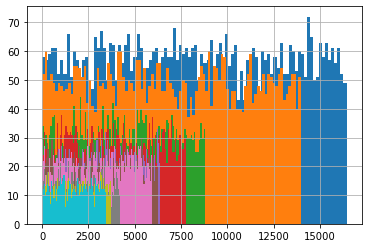

In [63]:
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

Понятно, что чем больше в принципе ресторанов (или обзоров на них) в городе, тем "больше" будет последнее место. Другими словами, 20 место в городе с маленьким количество обзоров и 20 место в городе с большим количеством обзоров это совсем разные вещи. Надо этот признак как то нормализовать.

In [64]:
df.groupby(['city']).ranking.max().sort_values()

city
Ljubljana       468.0
Luxembourg      621.0
Bratislava      889.0
Oslo           1137.0
Helsinki       1141.0
Krakow         1244.0
Geneva         1413.0
Oporto         1484.0
Zurich         1590.0
Edinburgh      1766.0
Athens         1787.0
Dublin         1960.0
Copenhagen     1964.0
Warsaw         2141.0
Budapest       2438.0
Stockholm      2464.0
Lyon           2666.0
Hamburg        2736.0
Munich         2763.0
Brussels       3004.0
Amsterdam      3249.0
Vienna         3444.0
Lisbon         3717.0
Prague         4188.0
Rome           5946.0
Milan          6275.0
Berlin         6372.0
Barcelona      7796.0
Madrid         8809.0
Paris         13986.0
London        16444.0
Name: ranking, dtype: float64

In [65]:
df.groupby(['city']).ranking.min().sort_values()

city
Amsterdam     1.0
Lisbon        1.0
Krakow        1.0
Hamburg       1.0
Lyon          1.0
Edinburgh     1.0
Warsaw        1.0
Madrid        1.0
Budapest      1.0
Oslo          1.0
Rome          1.0
Stockholm     1.0
Vienna        1.0
Milan         1.0
London        1.0
Prague        2.0
Luxembourg    2.0
Zurich        2.0
Berlin        2.0
Copenhagen    3.0
Munich        3.0
Brussels      3.0
Paris         3.0
Bratislava    3.0
Ljubljana     3.0
Oporto        4.0
Geneva        5.0
Barcelona     5.0
Helsinki      5.0
Athens        6.0
Dublin        8.0
Name: ranking, dtype: float64

In [66]:
df.groupby(['city']).ranking.mean().sort_values()

city
Ljubljana      239.907104
Luxembourg     313.719048
Bratislava     453.112957
Helsinki       566.909574
Oslo           568.288312
Krakow         614.553047
Geneva         708.286902
Oporto         738.473684
Zurich         782.486989
Edinburgh      873.041946
Athens         881.108280
Copenhagen     974.699545
Dublin         983.725111
Warsaw        1063.039890
Budapest      1220.811275
Stockholm     1242.386585
Lyon          1307.559417
Hamburg       1355.140148
Munich        1370.539754
Brussels      1535.347170
Amsterdam     1580.943831
Vienna        1706.102058
Lisbon        1877.126154
Prague        2077.387387
Rome          2983.397498
Milan         3098.143929
Berlin        3266.237123
Barcelona     3914.144111
Madrid        4388.423102
Paris         6933.012048
London        8198.461873
Name: ranking, dtype: float64

Судя по df.groupby(['city']).ranking.max().sort_values() и df.groupby(['city']).ranking.mean().sort_values() нумерация у нас почти сплошная, везде среднее значение примерно равно половине максимального. Давайте попробуем из каждого значения вычесть минимальное (для его города) и потом поделить на разницу между максимальным и минимальным:

In [67]:
city_min = {}
for city in cities:
    city_min[city] = df[df.city == city].ranking.min()
    
city_max = {}
for city in cities:
    city_max[city] = df[df.city == city].ranking.max()
    
city_delta = {}
for city in cities:
    city_delta[city] = df[df.city == city].ranking.max() - df[df.city == city].ranking.min()
    
def norm_ranking(row):
    return (row.ranking - city_min[row.city]) / city_delta[row.city]

df['ranking_norm'] = df.apply(norm_ranking, axis=1)

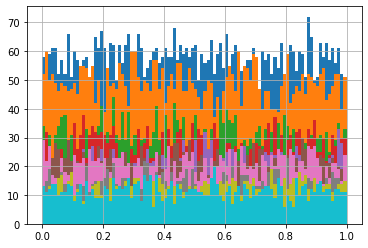

In [68]:
for x in (df['city'].value_counts())[0:10].index:
    df['ranking_norm'][df['city'] == x].hist(bins=100)
plt.show()

Теперь распределение признака в каждом городе выглядит одинаково

In [69]:
df.head()

,Restaurant_id,city,cuisine,ranking,rating,price_range,number_reviews,reviews,url_ta,id_ta,cuisine_is_nan,price_is_nan,number_reviews_is_nan,number_cuisines,Hungarian,British,Venezuelan,Sri Lankan,Cajun & Creole,Armenian,Czech,Malaysian,Wine Bar,Arabic,Southwestern,Fujian,Albanian,Brew Pub,Gastropub,Cambodian,Tibetan,Seafood,Thai,Fusion,Belgian,Grill,Portuguese,German,South American,Tunisian,Gluten Free Options,Bangladeshi,Soups,Peruvian,Sushi,Indian,Azerbaijani,Georgian,Healthy,Chilean,Spanish,Croatian,Welsh,Mediterranean,Singaporean,Swedish,New Zealand,Nepali,Slovenian,Argentinean,European,Dutch,Scottish,Fast Food,Italian,International,Romanian,Asian,Pub,Afghani,Xinjiang,Cuban,Diner,Lebanese,Pakistani,Norwegian,Yunnan,Colombian,Vegetarian Friendly,Middle Eastern,Greek,Native American,Indonesian,Australian,Street Food,Moroccan,Burmese,Ethiopian,Latin,Bar,Taiwanese,Polish,Central Asian,Halal,Canadian,Persian,Pizza,Danish,Balti,Chinese,Cafe,Israeli,Caucasian,Barbecue,Contemporary,Kosher,Caribbean,Filipino,Generic,Swiss,Japanese,Vegan Options,Egyptian,Polynesian,Austrian,Latvian,Ecuadorean,French,Turkish,Uzbek,Delicatessen,Brazilian,Steakhouse,Central European,Central American,Scandinavian,American,Salvadoran,Korean,Russian,Vietnamese,Irish,Jamaican,African,Mongolian,Mexican,Minority Chinese,Ukrainian,Hawaiian,Eastern European,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,city_pop,ranking_norm
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2175601,0.398126
1,id_1535,Stockholm,[Generic],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,975551,0.623630
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8961989,0.021407
3,id_3456,Berlin,[Generic],3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6177535,0.542543
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Теперь вытащим данные о тех двух (в некоторых случаях одном или вообще ни одном) отзывах, которые нам даны в исходном датасете.

In [70]:
def extract_data_1(cell):
    try:
        my_list = ast.literal_eval(cell)
    except:
        return np.nan
    if len(my_list[1]) != 0:
        return pd.to_datetime(my_list[1][0], format='%m/%d/%Y')
    else:
        return np.nan
    
def extract_data_2(cell):
    try:
        my_list = ast.literal_eval(cell)
    except:
        return np.nan
    if len(my_list[1]) == 2:
        return pd.to_datetime(my_list[1][1], format='%m/%d/%Y')
    else:
        return np.nan
    
df['review_date_1'] = df.reviews.apply(extract_data_1)
df['review_date_2'] = df.reviews.apply(extract_data_2)

Ещё получим разницу во времени между отзывами и "возраст" последнего отзыва

In [71]:
def calculate_timediff(row):
    if not pd.isna(row.review_date_1) and not pd.isna(row.review_date_2):
        return (abs(row.review_date_1 - row.review_date_2)).days
    
df['reviews_timediff'] = df.apply(lambda row: calculate_timediff(row), axis=1)

last_review_date = max(df.review_date_1.max(), df.review_date_2.max())

def calculate_review_age(row):
    if not pd.isna(row.review_date_1) and not pd.isna(row.review_date_2):
        return (last_review_date - max(row.review_date_1, row.review_date_2)).days
    elif not pd.isna(row.review_date_1):
        return (last_review_date - row.review_date_1).days
    
df['last_review_age'] = df.apply(lambda row: calculate_review_age(row), axis=1)

df.reviews_timediff.fillna(df.reviews_timediff.median(), inplace=True)
df.last_review_age.fillna(df.last_review_age.median(), inplace=True)

Заполним пропуски в столбце с количеством отзывов

Ещё добавлю столбец с количеством отзывов, делённым на население города - логично, что в маленьком городе ресторан получает меньше отзывов

In [72]:
df.number_reviews.fillna(df.number_reviews.median(), inplace=True)

In [73]:
df['number_reviews_div'] = df.number_reviews / df.city_pop

От выбросов чистить совсем нечего

Нормализуем все числовые признаки

In [74]:
scaler = MinMaxScaler()
df[['ranking', 'ranking_norm', 'number_reviews', 'number_reviews_div', 'reviews_timediff', 'last_review_age', 'number_cuisines', 'city_pop', ]] = scaler.fit_transform(df[['ranking', 'ranking_norm', 'number_reviews', 'number_reviews_div', 'reviews_timediff', 'last_review_age', 'number_cuisines', 'city_pop']])

In [ ]:
df.head()

Проверим наши признаки на корреляцию

In [75]:
small_df = df[['ranking', 'ranking_norm', 'number_reviews', 'number_reviews_div', 'city_pop', 'number_cuisines', 'reviews_timediff', 'last_review_age', 'rating']]

In [76]:
correlation = small_df.corr()

<AxesSubplot:>

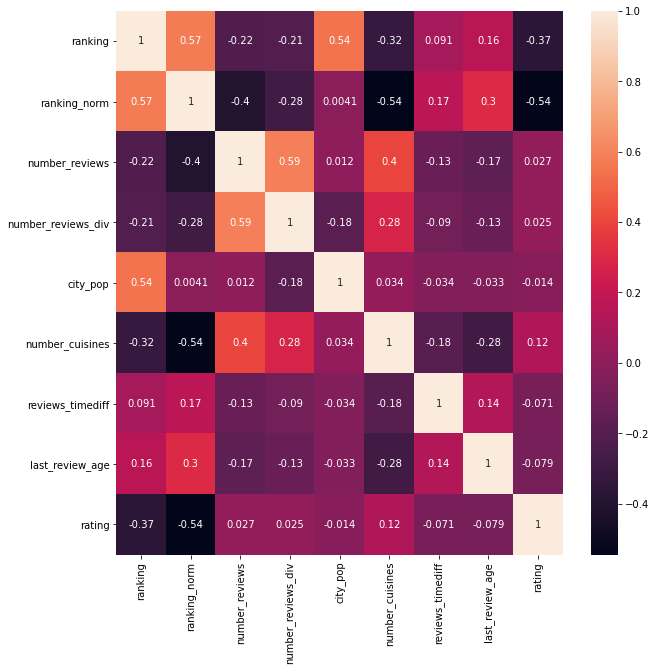

In [77]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(correlation, annot=True)

In [78]:
for col in ['city', 'cuisine_is_nan', 'price_is_nan', 'number_reviews_is_nan', 'Pizza', 'Fast Food', 'Greek', 'Italian', 'Scottish']:
    get_stat_dif(df, col, 'rating')

Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки cuisine_is_nan
Найдены статистически значимые различия для колонки price_is_nan
Найдены статистически значимые различия для колонки Pizza
Найдены статистически значимые различия для колонки Fast Food
Найдены статистически значимые различия для колонки Greek
Найдены статистически значимые различия для колонки Italian
Найдены статистически значимые различия для колонки Scottish


In [79]:
for col in ['Brazilian', 'Hawaiian', 'Seafood', 'Latvian', 'Salvadoran', 'Ukrainian', 'Taiwanese', 'Healthy', 'Scandinavian']:
    get_stat_dif(df, col, 'rating')

Найдены статистически значимые различия для колонки Hawaiian
Найдены статистически значимые различия для колонки Seafood
Найдены статистически значимые различия для колонки Ukrainian
Найдены статистически значимые различия для колонки Healthy
Найдены статистически значимые различия для колонки Scandinavian


C:\Users\Andy\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Andy\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Andy\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Andy\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [80]:
for col in ['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels']:
    get_stat_dif(df, col, 'rating')

Найдены статистически значимые различия для колонки Amsterdam
Найдены статистически значимые различия для колонки Athens
Найдены статистически значимые различия для колонки Barcelona
Найдены статистически значимые различия для колонки Berlin
Найдены статистически значимые различия для колонки Brussels


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [ ]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [88]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'rating', 'city', 'cuisine', 'reviews', 'id_ta', 'url_ta', 'ranking', 'review_date_1', 'review_date_2', 'number_reviews_div'], axis = 1)
y = df['rating']

In [89]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [90]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [91]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [92]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [93]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.205506
